# Assignment 1-1: K-Nearest Neighbors (k-NN)

In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

## Downloading the CIFAR-10 dataset 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download

In [2]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


## Loading raw files and reading them as training and testing datasets

In [3]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Visualizing dataset samples
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

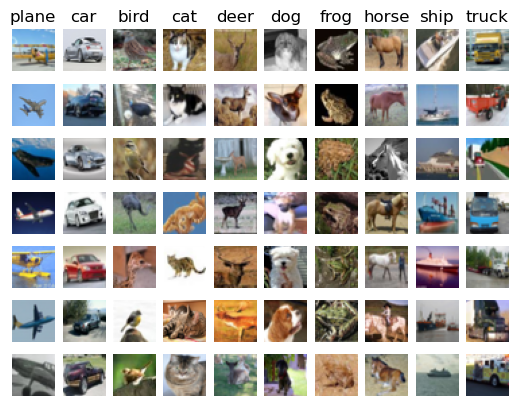

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

We will subsample the data to use only 500 training examples and 250 test examples:

In [5]:
# Memory error prevention by subsampling data

num_training = 500
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 250
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(500, 3072) (250, 3072)


# K-Nearest Neighbors (k-NN)

Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Perform k-Nearest neighbours algorithm on the CiFAR-10 dataset to classify test images. 
2. Perform k-fold cross validation and plot the trend line with error bars that correspond to standard deviation to find the best value of the 'k' hyper parameter and best accuracy on the dataset.
3. Select the best value for k, and rerun the classifier on our full 5000 set of training examples.
4. Discussion: Discuss your understanding.

In [11]:
!pip install imgaug

  Obtaining dependency information for imgaug from https://files.pythonhosted.org/packages/66/b1/af3142c4a85cba6da9f4ebb5ff4e21e2616309552caca5e8acefe9840622/imgaug-0.4.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for Shapely from https://files.pythonhosted.org/packages/b1/5a/6a67d929c467a1973b6bb9f0b00159cc343b02bf9a8d26db1abd2f87aa23/shapely-2.0.6-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/948.0 kB ? eta -:--:--
   - -------------------------------------- 30.7/948.0 kB 1.3 MB/s eta 0:00:01
   - ------------------------------------- 41.0/948.0 kB 487.6 kB/s eta 0:00:02
   - ------------------------------------- 41.0/948.0 kB 487.6 kB/s eta 0:00:02
   - ------------------------------------- 41.0/948.0 kB 487.6 kB/s eta 0:00:02
   --- ----------------------------------- 92.2/948.0 kB 403.5 kB/s eta 0:00:03
   ---- --------------------------------- 102.4/948.0 kB 346.5 kB/s eta 0:00:03
   ---- ---------------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for basic image operations
from imgaug import augmenters as iaa

# Load and preprocess your CIFAR-10 dataset as before
# (Assuming you have already done this and X_train, y_train, X_test, y_test are defined)

# Subsample data for quick testing
num_training = 500  # Change this to use more training samples if possible
num_test = 250
X_train = X_train[:num_training]
y_train = y_train[:num_training]
X_test = X_test[:num_test]
y_test = y_test[:num_test]

# Reshape data
X_train = np.reshape(X_train, (X_train.shape[0], -1))  # (500, 3072)
X_test = np.reshape(X_test, (X_test.shape[0], -1))    # (250, 3072)

# Normalize the data to float64 for processing, then convert back to uint8 for augmentation
X_train_normalized = (X_train / 255.0).astype(np.float32)
X_test_normalized = (X_test / 255.0).astype(np.float32)

# Define your augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flips
    iaa.Affine(rotate=(-20, 20)),  # Random rotations
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add noise
    iaa.Multiply((0.8, 1.2)),  # Brightness change
])

# Augment the training data
X_train_augmented = seq(images=(X_train_normalized * 255).astype(np.uint8).reshape(-1, 32, 32, 3))  # Reshape for augmentation
X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], -1)  # Flatten back

# Update training set to include augmented data
X_train_combined = np.concatenate((X_train_normalized, X_train_augmented / 255.0), axis=0)  # Normalize back
y_train_combined = np.concatenate((y_train, y_train), axis=0)  # Repeat labels for augmented data

# Initialize variables for k-NN
k_choices = [3, 5, 7, 9, 11]  # Using larger odd values for k
num_folds = 5
fold_size = X_train_combined.shape[0] // num_folds

# Cross-validation loop to find the best k
accuracies = []

for k in k_choices:
    fold_accuracies = []
    
    for i in range(num_folds):
        # Create the validation fold
        val_start = i * fold_size
        val_end = (i + 1) * fold_size
        X_val_fold = X_train_combined[val_start:val_end]
        y_val_fold = y_train_combined[val_start:val_end]
        
        # Create the training fold
        X_train_fold = np.concatenate([X_train_combined[:val_start], X_train_combined[val_end:]], axis=0)
        y_train_fold = np.concatenate([y_train_combined[:val_start], y_train_combined[val_end:]], axis=0)
        
        # Compute distances between training fold and validation fold
        dists = np.sqrt(np.sum((X_train_fold[:, np.newaxis, :] - X_val_fold[np.newaxis, :, :]) ** 2, axis=2))
        
        # Predict labels for validation set using weighted voting
        num_test_fold = dists.shape[1]
        y_val_pred = np.zeros(num_test_fold)
        for j in range(num_test_fold):
            # Sort distances and find k closest labels
            closest_y = y_train_fold[np.argsort(dists[:, j])[:k]]
            distances = np.sort(dists[:, j])[:k]
            weights = 1 / (distances + 1e-5)  # Avoid division by zero
            weighted_votes = np.bincount(closest_y, weights=weights)
            y_val_pred[j] = np.argmax(weighted_votes)
        
        # Calculate accuracy for this fold
        accuracy = np.mean(y_val_pred == y_val_fold)
        fold_accuracies.append(accuracy)
    
    # Store the mean accuracy for this k
    accuracies.append(np.mean(fold_accuracies))

# Plot results
plt.errorbar(k_choices, accuracies, yerr=np.std(fold_accuracies), fmt='o')
plt.title('Cross-validation Accuracy for different k values')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_choices)  # Set x-ticks to k_choices
plt.show()

# Best k selection
best_k = k_choices[np.argmax(accuracies)]
print('Best value for k:', best_k)

# Rerun on the full training set with the best k
# Using the full training set and test set
dists_final = np.sqrt(np.sum((X_train_combined[:, np.newaxis, :] - X_test_normalized[np.newaxis, :, :]) ** 2, axis=2))
y_test_pred = np.zeros(X_test.shape[0])
for i in range(X_test.shape[0]):
    closest_y_final = y_train_combined[np.argsort(dists_final[:, i])[:best_k]]
    distances = np.sort(dists_final[:, i])[:best_k]
    weights = 1 / (distances + 1e-5)  # Avoid division by zero
    weighted_votes = np.bincount(closest_y_final, weights=weights)
    y_test_pred[i] = np.argmax(weighted_votes)

# Calculate the final accuracy on the test set
test_accuracy = np.mean(y_test_pred == y_test)
print('Test set accuracy with best k:', test_accuracy)
